# Введение

Я буду работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси.

**Цель**: Спрогнозировать общую продолжительность поездок на такси в Нью-Йорке.

**Метрика**: RMSLE (Root Mean Squared Logarithmic Error).

**Подход**: Linear Regression (Ridge/Lasso) с Feature Engineering.

Структура датасета:
- **id** — уникальный идентификатор каждой поездки
- **vendor_id** — код провайдера/перевозчика, которому принадлежит запись о поездке
- **pickup_datetime** — дата и время, когда был включён счётчик (начало поездки)
- **dropoff_datetime** — дата и время, когда был выключен счётчик (конец поездки)
- **passenger_count** — количество пассажиров в машине (вводится водителем)
- **pickup_longitude** — долгота точки, где включили счётчик (место начала)
- **pickup_latitude** — широта точки, где включили счётчик (место начала)
- **dropoff_longitude** — долгота точки, где выключили счётчик (место окончания)
- **dropoff_latitude** — широта точки, где выключили счётчик (место окончания)
- **store_and_fwd_flag** — флаг “store and forward”: показывает, сохранялась ли запись о поездке в памяти автомобиля перед отправкой провайдеру из-за отсутствия связи с сервером; Y = сохранялась и отправлялась позже, N = отправлялась сразу
- **trip_duration** — длительность поездки в секундах

---

# Импорт библиотек, задание констант

In [535]:
!pip install folium haversine

In [536]:
from typing import Iterable

import folium
from haversine import haversine
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [537]:
JFK_COORD = (40.6413, -73.7781)
LGA_COORD = (40.7772, -73.8726)
SEED = 42

# Загрузка и первичная обработка данных

In [538]:
df = pd.read_csv("./data/train.csv")

In [539]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [540]:
df.shape

(1458644, 11)

In [541]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [542]:
df.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [543]:
df.duplicated().sum()

np.int64(0)

In [544]:
df_test = pd.read_csv("./data/test.csv")
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [545]:
df_test.shape, df_test.columns

((625134, 9),
 Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
        'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
        'dropoff_latitude', 'store_and_fwd_flag'],
       dtype='object'))

Колонка `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [546]:
df = df.drop(labels=["dropoff_datetime"], axis=1)

In [547]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   passenger_count     1458644 non-null  int64         
 4   pickup_longitude    1458644 non-null  float64       
 5   pickup_latitude     1458644 non-null  float64       
 6   dropoff_longitude   1458644 non-null  float64       
 7   dropoff_latitude    1458644 non-null  float64       
 8   store_and_fwd_flag  1458644 non-null  object        
 9   trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 111.3+ MB


In [548]:
df["pickup_datetime"].isna().sum()

np.int64(0)

# Разведывательный анализ данных (EDA)

### Target Distribution

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуем его гистограмму:

In [549]:
df["trip_duration"].describe(percentiles=[0.5, 0.9, 0.95, 0.99, 0.999]).astype(
    int
)

count    1458644
mean         959
std         5237
min            1
50%          662
90%         1634
95%         2104
99%         3440
99.9%      85128
max      3526282
Name: trip_duration, dtype: int64

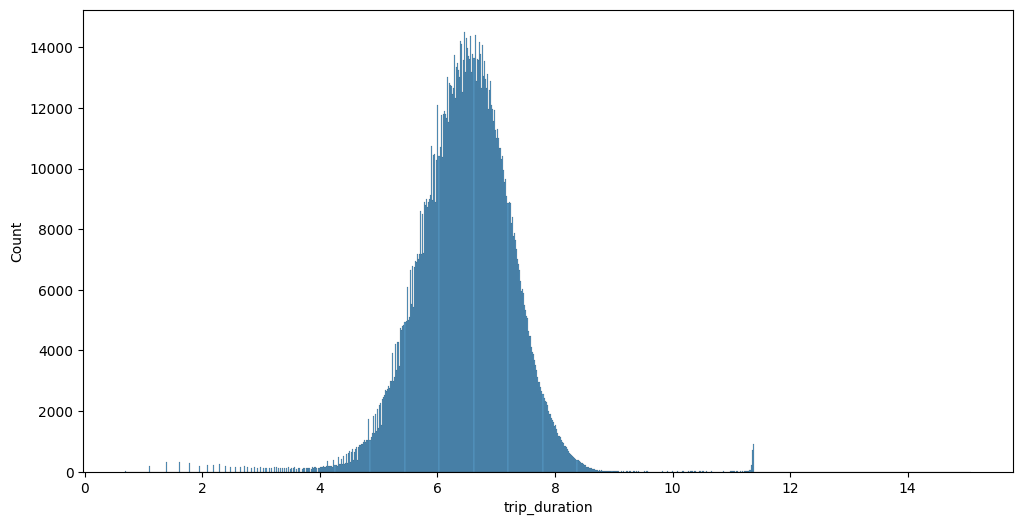

In [550]:
plt.figure(figsize=(12, 6))
sns.histplot(np.log1p(df["trip_duration"]))
plt.show()

Видим **тяжелый правый хвост**. 99% поездок находятся в разумных пределах - 3440 секунд (~1 час), при этом максимальная продолжительность поездки - 3526282 (~40 дней). Средняя продолжительность поездки - 662 секунды (~11 минут).

### Временной анализ

**Рассмотрим зависимость количества поездок от дня недели, времени суток и дня в году.**

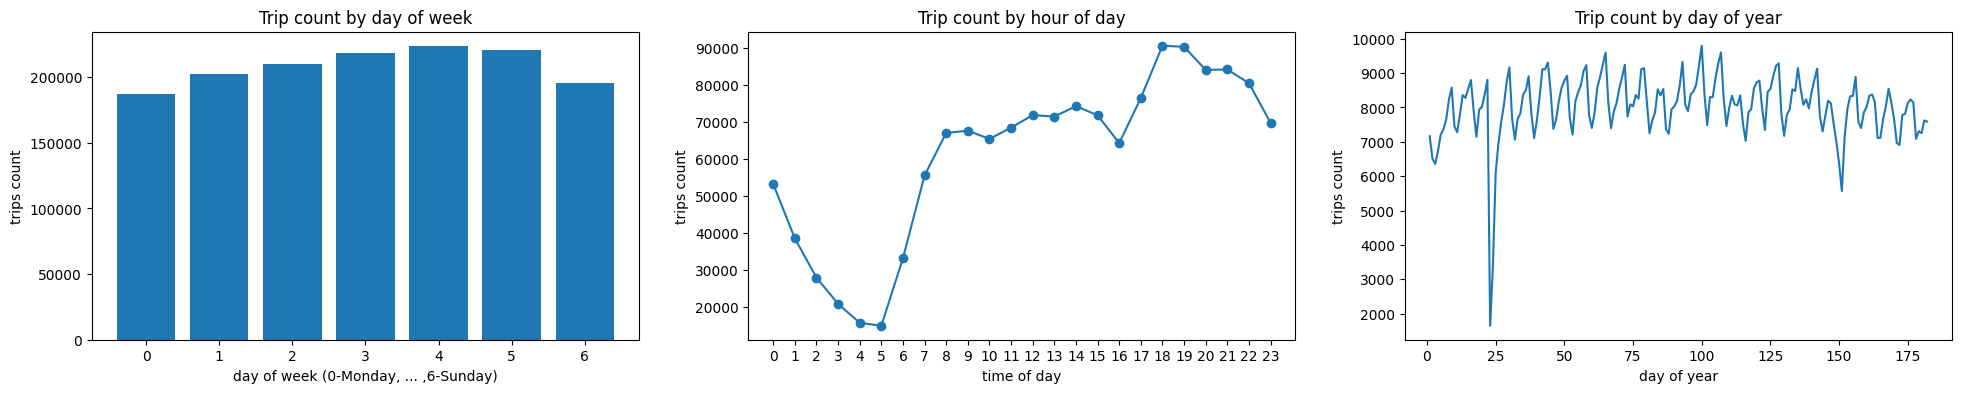

In [551]:
day_of_year = df["pickup_datetime"].dt.dayofyear.value_counts().sort_index()
day_of_week = df["pickup_datetime"].dt.day_of_week.value_counts().sort_index()
time_of_day = df["pickup_datetime"].dt.hour.value_counts().sort_index()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 4))

ax1.bar(day_of_week.index, day_of_week.values)
ax1.set_xlabel("day of week (0-Monday, ... ,6-Sunday)")
ax1.set_ylabel("trips count")
ax1.set_title("Trip count by day of week")

ax2.plot(time_of_day.index, time_of_day.values, marker="o")
ax2.set_xlabel("time of day")
ax2.set_ylabel("trips count")
ax2.set_xticks(range(24))
ax2.set_title("Trip count by hour of day")

ax3.plot(day_of_year.index, day_of_year.values)
ax3.set_xlabel("day of year")
ax3.set_ylabel("trips count")
ax3.set_title("Trip count by day of year")

plt.show()

Видим на графике количества поездок по дням в году 2 периода с аномально маленькими количествами поездок.

In [552]:
df.groupby(df["pickup_datetime"].dt.date).size().sort_index().nsmallest(5)

pickup_datetime
2016-01-23    1648
2016-01-24    3383
2016-05-30    5570
2016-01-25    6084
2016-01-03    6353
dtype: int64

1. **23 января 2016** года Нью-Йорк пережил рекордную **снежную бурю** (Blizzard of 2016), которая принесла более двух футов снега, вызвала запрет на передвижение, остановила транспорт (автобусы, надземное метро) и привела к отмене тысяч рейсов в аэропортах. Поэтому на графике видим аномальное низкое количество поездок - 1648.
2. **30 мая 2016** года в Нью-Йорке отмечался День поминовения (Memorial Day). В этот день проводилось большое количество парадов в городе, из-за чего дорого могли быть перекрыты. Следовательно в этот день наблюдалось меньшее чем обычно количество поекздок - 5570.

In [553]:
trips_series = df.groupby(
    [df["pickup_datetime"].dt.hour, df["pickup_datetime"].dt.month]
).size()
trips_series.index.names = ["hour", "month"]
trips_month = trips_series.reset_index(name="trips")
trips_month["month"] = trips_month["month"].map(
    {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun"}
)
trips_month.head()

,hour,month,trips
0,0,Jan,8330
1,0,Feb,8445
2,0,Mar,8992
3,0,Apr,9185
4,0,May,9146


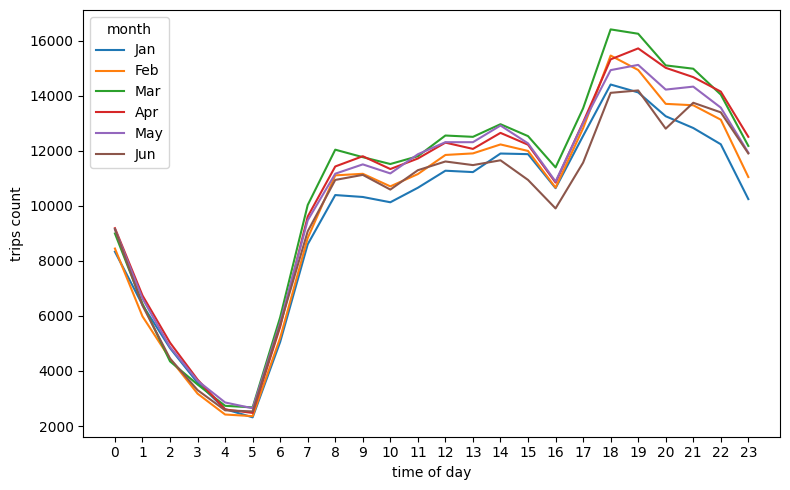

In [554]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=trips_month, x="hour", y="trips", hue="month")
plt.xticks(range(24))
plt.xlabel("time of day")
plt.ylabel("trips count")
plt.tight_layout()
plt.show()

Графики по месяцам показывают почти одинаковый суточный профиль спроса: минимум ночью (примерно 4–6 часов), резкий рост утром и максимальный пик вечером (около 18–20 часов). Отличия между месяцами в основном в общем уровне числа поездок, а не в форме кривой.

In [555]:
trip_series = df.groupby(
    [df["pickup_datetime"].dt.hour, df["pickup_datetime"].dt.day_of_week]
).size()
trip_series.index.names = ["hour", "day_of_week"]
trips_days_of_week = trip_series.reset_index(name="trips")
trips_days_of_week["day_of_week"] = trips_days_of_week["day_of_week"].map(
    {
        0: "Monday",
        1: "Tuesday",
        2: "Wednesday",
        3: "Thursday",
        4: "Friday",
        5: "Saturday",
        6: "Sunday",
    }
)
trips_days_of_week.head()

,hour,day_of_week,trips
0,0,Monday,4299
1,0,Tuesday,4506
2,0,Wednesday,5327
3,0,Thursday,6299
4,0,Friday,8779


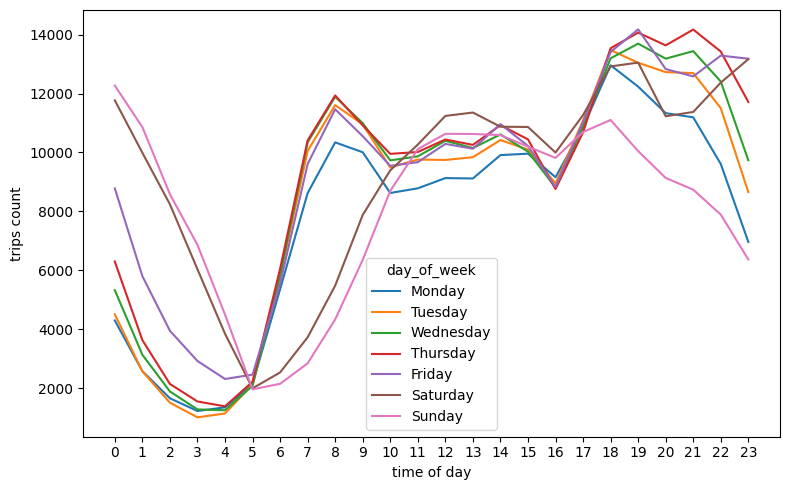

In [556]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=trips_days_of_week, x="hour", y="trips", hue="day_of_week")
plt.xlabel("time of day")
plt.ylabel("trips count")
plt.xticks(range(24))
plt.tight_layout()
plt.show()

В будни суточный профиль похож: основной поток приходится на утренние часы (7–9) и особенно на вечерний пик (18–20). В выходные и в пятницу заметно больше ночных поездок (0–2) и позже начинается дневная активность, что отражает смещение спроса в сторону вечерне-ночного времени.

Итого: по графикам видно стабильную суточную сезонность: минимум поездок ночью (≈4–6), рост утром и пик вечером (≈18–20), что отражает повседневный ритм города. По дням недели выделяются пятница и особенно суббота — больше поздневечерних и ночных поездок, тогда как будни похожи между собой; по месяцам форма профиля почти одинаковая, меняется в основном общий уровень. Отдельно заметны два резких провала по дням года, связанные с внешними событиями (метель и праздничные перекрытия).

**Рассмотрим зависимость продолжительности поездки от дня недели, времени суток и дня в году.**

In [557]:
X = df.drop(labels=["trip_duration"], axis=1)
y = df["trip_duration"]

X_train_eda, X_test_eda, y_train_eda, y_test_eda = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=SEED
)

X_train_eda.shape, y_train_eda.shape, X_test_eda.shape, y_test_eda.shape

((1021050, 9), (1021050,), (437594, 9), (437594,))

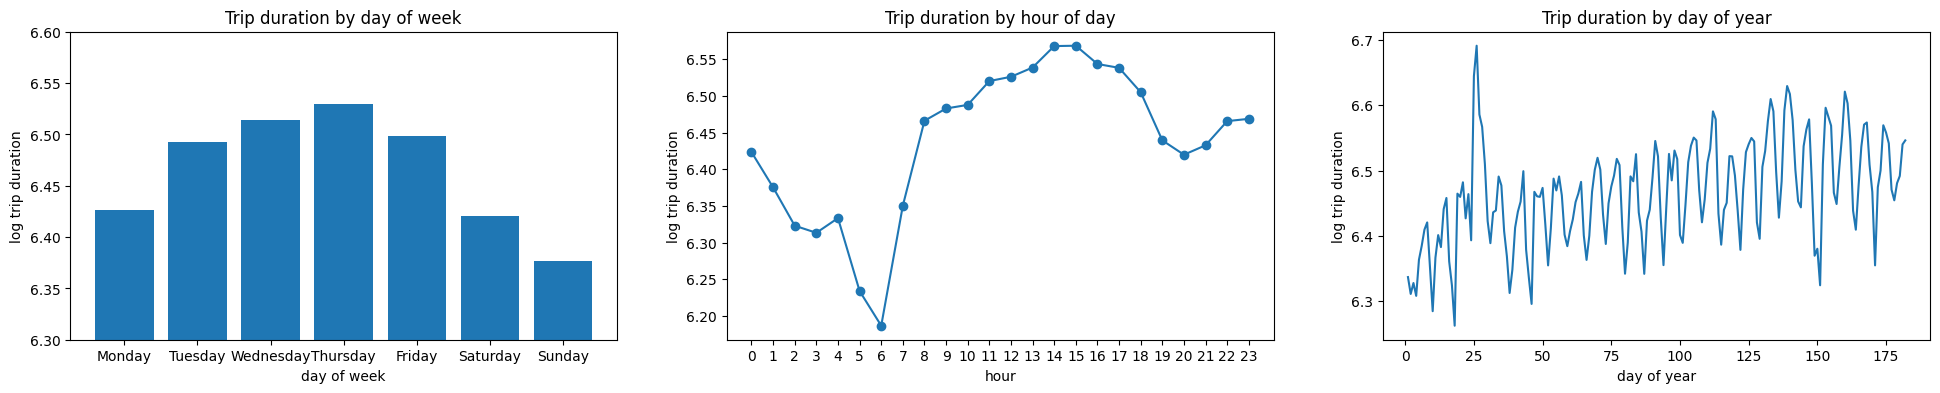

In [558]:
train_df = X_train_eda.copy()
train_df["trip_duration"] = y_train_eda
train_df["day_of_week"] = train_df["pickup_datetime"].dt.day_of_week.map(
    {
        0: "Monday",
        1: "Tuesday",
        2: "Wednesday",
        3: "Thursday",
        4: "Friday",
        5: "Saturday",
        6: "Sunday",
    }
)
train_df["hour"] = train_df["pickup_datetime"].dt.hour
train_df["day_of_year"] = train_df["pickup_datetime"].dt.day_of_year
train_df["log_trip_duration"] = np.log1p(train_df["trip_duration"])

order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
res_for_day_of_week = (
    train_df.groupby("day_of_week")["log_trip_duration"].mean().reindex(order)
)
res_for_hour = train_df.groupby("hour")["log_trip_duration"].mean()
res_for_day_of_year = train_df.groupby("day_of_year")[
    "log_trip_duration"
].mean()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 4))

ax1.bar(res_for_day_of_week.index, res_for_day_of_week.values)
ax1.set_xlabel("day of week")
ax1.set_ylabel("log trip duration")
ax1.set_title("Trip duration by day of week")
ax1.set_ylim(6.3, 6.6)

ax2.plot(res_for_hour.index, res_for_hour.values, marker="o")
ax2.set_xlabel("hour")
ax2.set_ylabel("log trip duration")
ax2.set_title("Trip duration by hour of day")
ax2.set_xticks(range(24))

ax3.plot(res_for_day_of_year.index, res_for_day_of_year.values)
ax3.set_xlabel("day of year")
ax3.set_ylabel("log trip duration")
ax3.set_title("Trip duration by day of year")
plt.show()

**Корреляция количества и длительности (Counts vs Duration)**. Графики не похожи и часто демонстрируют обратную зависимость, так как спрос не равен загруженности дорог:
- **По дням недели**: Максимум поездок — в пятницу/субботу (досуг), но максимум длительности — в четверг (рабочий трафик). В воскресенье дорожная сеть разгружена: поездок много, но они быстрые.
- **По часам**: Пик заказов в 18:00–19:00 (возвращение с работы), но самые долгие поездки — в разгар рабочего дня (14:00–15:00), когда средняя скорость потока в центре падает.

**Аномалии (Снежный шторм)**. В период ~23–24 дня года (конец января) наблюдается экстремальное расхождение:
- **Количество** поездок падает почти до нуля (водители не вышли на линию).
- **Длительность** дает резкий выброс вверх.
Причина этого в том, что те немногие машины, что работали в снегопад, передвигались с критически низкой скоростью.

На графике `day_of_year` виден отчетливый восходящий тренд. Средняя длительность поездки плавно растет от зимы к лету. Это объясняется сезонным уплотнением трафика: улучшение погоды, рост туристического потока и начало дорожных работ.

**Добавим следующие признаки на основе `pickup_datetime`:**
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [559]:
def add_time_features(df):
    df = df.copy()
    dt = df["pickup_datetime"].dt
    df["pickup_day_of_week"] = dt.day_of_week
    df["pickup_month"] = dt.month
    df["pickup_hour"] = dt.hour
    df["pickup_day_of_year"] = dt.dayofyear
    df["is_anomaly_period"] = (
        df["pickup_day_of_year"].between(23, 24)
        | ((df["pickup_month"] == 5) & (df["pickup_datetime"].dt.day == 30))
    ).astype(int)
    return df

In [560]:
X_train_eda = add_time_features(X_train_eda)
X_test_eda = add_time_features(X_test_eda)

In [561]:
X_train_eda.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_day_of_week,pickup_month,pickup_hour,pickup_day_of_year,is_anomaly_period
1011257,id2209155,2,2016-05-03 09:03:08,2,-73.979813,40.752529,-73.982681,40.763680,N,1,5,9,124,0
178550,id0586605,1,2016-01-01 16:40:51,1,-73.977623,40.746296,-73.968414,40.788933,N,4,1,16,1,0
551460,id0467144,1,2016-04-24 13:57:03,1,-73.950699,40.779404,-73.863129,40.768608,N,6,4,13,115,0
1434271,id0989010,2,2016-01-10 17:03:47,1,-73.984558,40.721802,-73.976753,40.752213,N,6,1,17,10,0
1173610,id0580742,1,2016-02-25 17:37:36,1,-73.967720,40.768742,-73.977173,40.789875,N,3,2,17,56,0


In [562]:
X_train_eda["is_anomaly_period"].value_counts()

is_anomaly_period
0    1013602
1       7448
Name: count, dtype: int64

Чтобы иметь некоторую точку отсчета, посчитаем значение метрики RMSLE при наилучшем константном предсказании:

In [563]:
def rmsle(log1p_y_true, log1p_y_pred):
    return np.sqrt(np.mean((log1p_y_pred - log1p_y_true) ** 2))


logy = np.log1p(df["trip_duration"].values)
const_pred = np.full_like(logy, logy.mean())
rmsle_best_const = rmsle(logy, const_pred)
rmsle_best_const

np.float64(0.7957592365411507)

Обучим `Ridge`-регрессию с параметрами по умолчанию, закодировов все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируем с помощью `StandardScaler`. Делаем это для того, чтобы сравнивать оценивать полезность добавляемых признаков в дальнейшем.

В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объединим редкие категории в одну с помощью min_frequency=50 в OneHotEncoder.

In [564]:
def get_pipeline(cat_cols, num_cols, model):
    preprocessor = ColumnTransformer(
        transformers=[
            (
                "cat",
                OneHotEncoder(handle_unknown="ignore", min_frequency=50),
                cat_cols,
            ),
            ("num", StandardScaler(), num_cols),
        ],
        remainder="drop",
    )
    return Pipeline([("prep", preprocessor), ("model", model)])

In [565]:
cat_columns = [
    "vendor_id",
    "store_and_fwd_flag",
    "pickup_day_of_week",
    "pickup_month",
    "pickup_hour",
    "is_anomaly_period",
]
num_columns = [
    "passenger_count",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "pickup_day_of_year",
]

model = get_pipeline(
    cat_columns, num_columns, Ridge(alpha=1.0, random_state=SEED)
)

model.fit(X_train_eda, np.log1p(y_train_eda))
y_pred_eda = model.predict(X_test_eda)
score = root_mean_squared_error(np.log1p(y_test_eda), y_pred_eda)
print(f"RMSLE score: {score}")

RMSLE score: 0.7724470022479375


На данном этапе RMSLE score модели чуть ниже константного предсказания

### Пространственный анализ

**Изучим координаты начала и конца поездок**

Отобразим 1000 случайных наблюдений на карте Нью Йорка.

In [566]:
def show_circles_on_map(
    latitude_values: Iterable[float],
    longitude_values: Iterable[float],
    color: str = "blue",
) -> folium.Map:
    location = (np.mean(latitude_values), np.mean(longitude_values))
    m = folium.Map(location=location)

    for lat, lon in zip(latitude_values, longitude_values):
        folium.Circle(
            radius=100,
            location=(lat, lon),
            color=color,
            fill_color=color,
            fill=True,
        ).add_to(m)

    return m

In [567]:
random_sample = df.sample(1000)

your_lat_values = random_sample["pickup_latitude"]
your_lon_values = random_sample["pickup_longitude"]

m = show_circles_on_map(your_lat_values, your_lon_values, color="midnightblue")
m

На карте явно выделяется плотный кластер в **Манхэттене** - это основной центр спроса, где много коротких городских поездок и сильная зависимость длительности от времени суток и пробок. **Можно в дальнейшем выделить признак, который определяет, попадает ли точка в Манхэттен.**

Отдельно видны кластеры около крупных **аэропортов**. Такие поездки часто длиннее и имеют другой "режим" длительностей и маршрутов, поэтому **полезно выделять близость к аэропорту как отдельный признак.**

На основе координат точки посадки и точки высадки вычислим пройденное за поездку расстоение. Точное расстояние мы определить не сможем, но можно вычислить кратчайшее расстояние между точками.

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние. Запишем логарифм `haversine` в отдельную колонку `log_haversine`

In [568]:
def add_distance_features(df):
    df = df.copy()
    df["haversine_km"] = df.apply(
        lambda r: haversine(
            (r["pickup_latitude"], r["pickup_longitude"]),
            (r["dropoff_latitude"], r["dropoff_longitude"]),
        ),
        axis=1,
    )
    df["log_haversine"] = np.log1p(df["haversine_km"])
    return df


X_train_eda = add_distance_features(X_train_eda)
X_test_eda = add_distance_features(X_test_eda)
X_train_eda.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_day_of_week,pickup_month,pickup_hour,pickup_day_of_year,is_anomaly_period,haversine_km,log_haversine
1011257,id2209155,2,2016-05-03 09:03:08,2,-73.979813,40.752529,-73.982681,40.763680,N,1,5,9,124,0,1.263189,0.816775
178550,id0586605,1,2016-01-01 16:40:51,1,-73.977623,40.746296,-73.968414,40.788933,N,4,1,16,1,0,4.804019,1.758551
551460,id0467144,1,2016-04-24 13:57:03,1,-73.950699,40.779404,-73.863129,40.768608,N,6,4,13,115,0,7.471099,2.136660
1434271,id0989010,2,2016-01-10 17:03:47,1,-73.984558,40.721802,-73.976753,40.752213,N,6,1,17,10,0,3.444874,1.491751
1173610,id0580742,1,2016-02-25 17:37:36,1,-73.967720,40.768742,-73.977173,40.789875,N,3,2,17,56,0,2.481066,1.247339


Посчитаем корреляцию и убедимся, что логарифм расстояния лучше отражает таргет, чем просто расстояние:

In [569]:
analysis_df = X_train_eda.copy()
analysis_df["log_trip_duration"] = np.log1p(y_train_eda)

corr = analysis_df[
    ["haversine_km", "log_haversine", "log_trip_duration"]
].corr()
corr

,haversine_km,log_haversine,log_trip_duration
haversine_km,1.000000,0.833329,0.565406
log_haversine,0.833329,1.000000,0.749960
log_trip_duration,0.565406,0.749960,1.000000


0.74 > 0.56 -> логарифм расстояния лучше отражает таргет

**Изучим среднюю скорость движения такси**

In [570]:
X_train_eda["average_speed"] = 3600 * X_train_eda["haversine_km"] / y_train_eda
X_train_eda.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_day_of_week,pickup_month,pickup_hour,pickup_day_of_year,is_anomaly_period,haversine_km,log_haversine,average_speed
1011257,id2209155,2,2016-05-03 09:03:08,2,-73.979813,40.752529,-73.982681,40.763680,N,1,5,9,124,0,1.263189,0.816775,5.388008
178550,id0586605,1,2016-01-01 16:40:51,1,-73.977623,40.746296,-73.968414,40.788933,N,4,1,16,1,0,4.804019,1.758551,17.277190
551460,id0467144,1,2016-04-24 13:57:03,1,-73.950699,40.779404,-73.863129,40.768608,N,6,4,13,115,0,7.471099,2.136660,25.664079
1434271,id0989010,2,2016-01-10 17:03:47,1,-73.984558,40.721802,-73.976753,40.752213,N,6,1,17,10,0,3.444874,1.491751,15.818298
1173610,id0580742,1,2016-02-25 17:37:36,1,-73.967720,40.768742,-73.977173,40.789875,N,3,2,17,56,0,2.481066,1.247339,12.201965


In [571]:
X_train_eda["average_speed"].describe(
    percentiles=[0.5, 0.75, 0.9, 0.95, 0.99, 0.999]
).astype(int)

count    1021050
mean          14
std           15
min            0
50%           12
75%           17
90%           24
95%           29
99%           40
99.9%         54
max         9274
Name: average_speed, dtype: int64

Видим огромный выброс - max: 9274. Посмотрим на гистограмму распрелеления скорости по объектам, для которых значения скорости получились разумными - до 99.9 квантиля. 

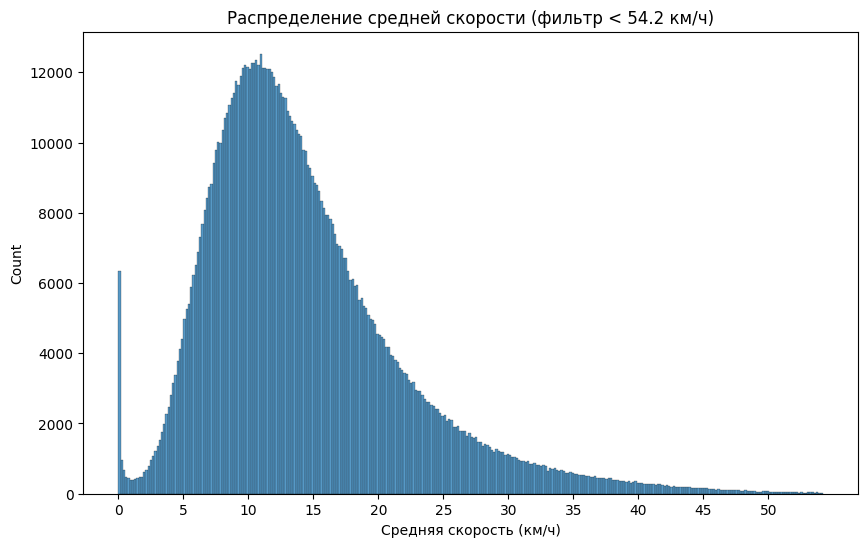

In [572]:
q999 = X_train_eda["average_speed"].quantile(0.999)
reasonable_df = X_train_eda[X_train_eda["average_speed"] < q999]

plt.figure(figsize=(10, 6))
sns.histplot(
    reasonable_df["average_speed"],
)
plt.title(f"Распределение средней скорости (фильтр < {q999:.1f} км/ч)")
plt.xlabel("Средняя скорость (км/ч)")
plt.xticks(range(0, 55, 5))
plt.show()

Как видно из describe() и гистограммы - средняя скорость такси находится в районе 12 км/ч, в редких случая может достигать 50 км/ч - ночью при отсутствии трафика.
Также из графика можно наблюдать существенный процент поездок, где скорость нулевая, посмотрим на них поближе

In [573]:
zero_speed_trips = X_train_eda[X_train_eda["average_speed"] == 0].copy()
zero_speed_trips["trip_duration"] = y_train_eda
zero_speed_trips[
    ["trip_duration", "haversine_km", "pickup_day_of_week", "pickup_hour"]
].sort_values(by="trip_duration", ascending=False).head(10)

,trip_duration,haversine_km,pickup_day_of_week,pickup_hour
120183,85333,0.0,4,15
607368,5929,0.0,2,16
149352,4683,0.0,2,17
819760,4578,0.0,2,9
848647,4280,0.0,1,16
674657,4217,0.0,0,14
1274384,4207,0.0,4,18
1128312,3733,0.0,2,14
1355568,3703,0.0,1,11
796718,3648,0.0,4,9


Видим, что нулевые значения скорости - это не ошибки в вычислениях. Нулевую скорость имеют поездки "туда-обратно". Из-за того, что у них совпадают координаты pickup и dropoff, haversine получилось нулевым, из-за чего скорость тоже стала нулевой.

**Рассмотрим как распределяется средняя скорость по дням недели и времени суток**

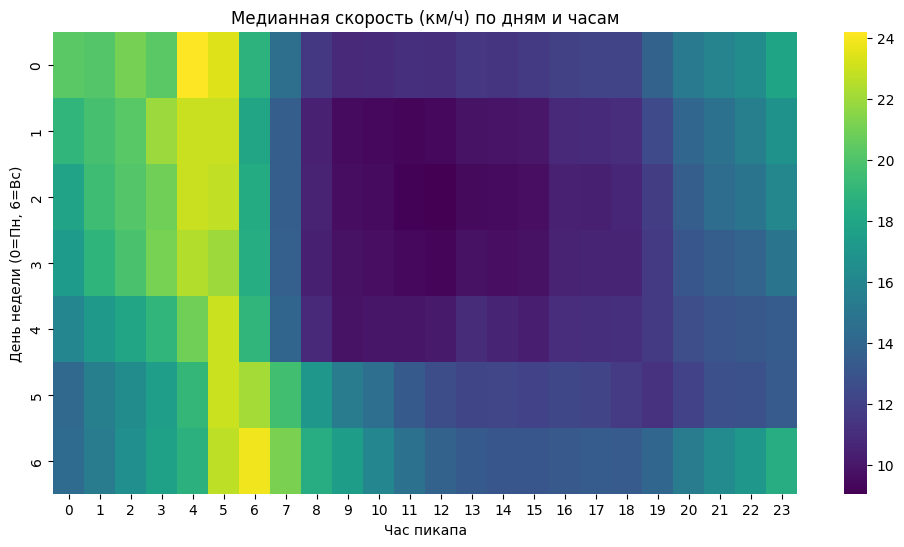

In [574]:
speed_pivot = X_train_eda.pivot_table(
    index="pickup_day_of_week",
    columns="pickup_hour",
    values="average_speed",
    aggfunc="median",
)

plt.figure(figsize=(12, 6))
sns.heatmap(speed_pivot, cmap="viridis", annot=False)
plt.title("Медианная скорость (км/ч) по дням и часам")
plt.xlabel("Час пикапа")
plt.ylabel("День недели (0=Пн, 6=Вс)")
plt.show()

Скорость минимальна во время пробок - это будние дни(Пн-Пт) примерно с 08:00 до 18:00, в это время медианная скорость падает до значения 10-12 км/ч.

Скорость максимальна в выходные утром - с 05:00 до 06:00, а также в будние дни с 04:00 до 05:00. В это время скорость достигает 22-24 км/ч.

Создадим на основе этих наблюдений признаки: **"поездка совершается в период пробок"** и **"поездка совершается в период свободных дорог"**.

In [575]:
def add_time_features(df):
    df = df.copy()
    dt = df["pickup_datetime"].dt
    df["pickup_day_of_week"] = dt.day_of_week
    df["pickup_month"] = dt.month
    df["pickup_hour"] = dt.hour
    df["pickup_day_of_year"] = dt.dayofyear
    df["is_anomaly_period"] = (
        df["pickup_day_of_year"].between(23, 24)
        | ((df["pickup_month"] == 5) & (df["pickup_datetime"].dt.day == 30))
    ).astype(int)
    return df


X_train_eda = add_time_features(X_train_eda)
X_test_eda = add_time_features(X_test_eda)

In [576]:
def add_traffic_features(df):
    df = df.copy()
    df["is_rush_hour"] = (
        (df["pickup_day_of_week"].between(0, 4))
        & (df["pickup_hour"].between(8, 18))
    ).astype(int)
    df["is_free_flow"] = (
        (
            (df["pickup_day_of_week"].between(5, 6))
            & (df["pickup_hour"].between(5, 6))
        )
        | (
            (df["pickup_day_of_week"].between(0, 4))
            & (df["pickup_hour"].between(4, 5))
        )
    ).astype(int)
    return df


X_train_eda = add_traffic_features(X_train_eda)
X_test_eda = add_traffic_features(X_test_eda)

Удалим колонку со значеним скорость из X_train, так как она может привести к утечке данных. `average_speed` вычисляется с помощью `trip_duration`, следовательно модель выучит time=distance/speed и выдаст идеальные предсказания на тренировчном датасете. Но на тестовых данных нет trip_duration, а значит, скорость вычислить не получится, пайплайн будет сломан

In [577]:
X_train_eda = X_train_eda.drop(labels=["average_speed"], axis=1)
X_train_eda.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_day_of_week,pickup_month,pickup_hour,pickup_day_of_year,is_anomaly_period,haversine_km,log_haversine,is_rush_hour,is_free_flow
1011257,id2209155,2,2016-05-03 09:03:08,2,-73.979813,40.752529,-73.982681,40.763680,N,1,5,9,124,0,1.263189,0.816775,1,0
178550,id0586605,1,2016-01-01 16:40:51,1,-73.977623,40.746296,-73.968414,40.788933,N,4,1,16,1,0,4.804019,1.758551,1,0
551460,id0467144,1,2016-04-24 13:57:03,1,-73.950699,40.779404,-73.863129,40.768608,N,6,4,13,115,0,7.471099,2.136660,0,0
1434271,id0989010,2,2016-01-10 17:03:47,1,-73.984558,40.721802,-73.976753,40.752213,N,6,1,17,10,0,3.444874,1.491751,0,0
1173610,id0580742,1,2016-02-25 17:37:36,1,-73.967720,40.768742,-73.977173,40.789875,N,3,2,17,56,0,2.481066,1.247339,1,0


**Добавим признаки, описывающие принадлежность к конкретным точкам на карте - аэропортам и Манхэттену**

In [578]:
def add_airport_features(df):
    df = df.copy()

    def is_near(lat1, lon1, airport_coord, threshold=3):
        dist = df.apply(
            lambda r: haversine((r[lat1], r[lon1]), airport_coord), axis=1
        )
        return (dist < threshold).astype(int)

    def is_in_box(lat_col, lon_col):
        return (
            df[lat_col].between(40.70, 40.88)
            & df[lon_col].between(-74.02, -73.93)
        ).astype(int)

    df["is_pickup_near_jfk"] = is_near(
        "pickup_latitude", "pickup_longitude", JFK_COORD
    )
    df["is_dropoff_near_jfk"] = is_near(
        "dropoff_latitude", "dropoff_longitude", JFK_COORD
    )

    df["is_pickup_near_lga"] = is_near(
        "pickup_latitude", "pickup_longitude", LGA_COORD
    )
    df["is_dropoff_near_lga"] = is_near(
        "dropoff_latitude", "dropoff_longitude", LGA_COORD
    )

    df["is_pickup_manhattan"] = is_in_box(
        "pickup_latitude", "pickup_longitude"
    )
    df["is_dropoff_manhattan"] = is_in_box(
        "dropoff_latitude", "dropoff_longitude"
    )

    return df


X_train_eda = add_airport_features(X_train_eda)
X_test_eda = add_airport_features(X_test_eda)

Посмотрим, какую связь имеют добавленные признаки с таргетом

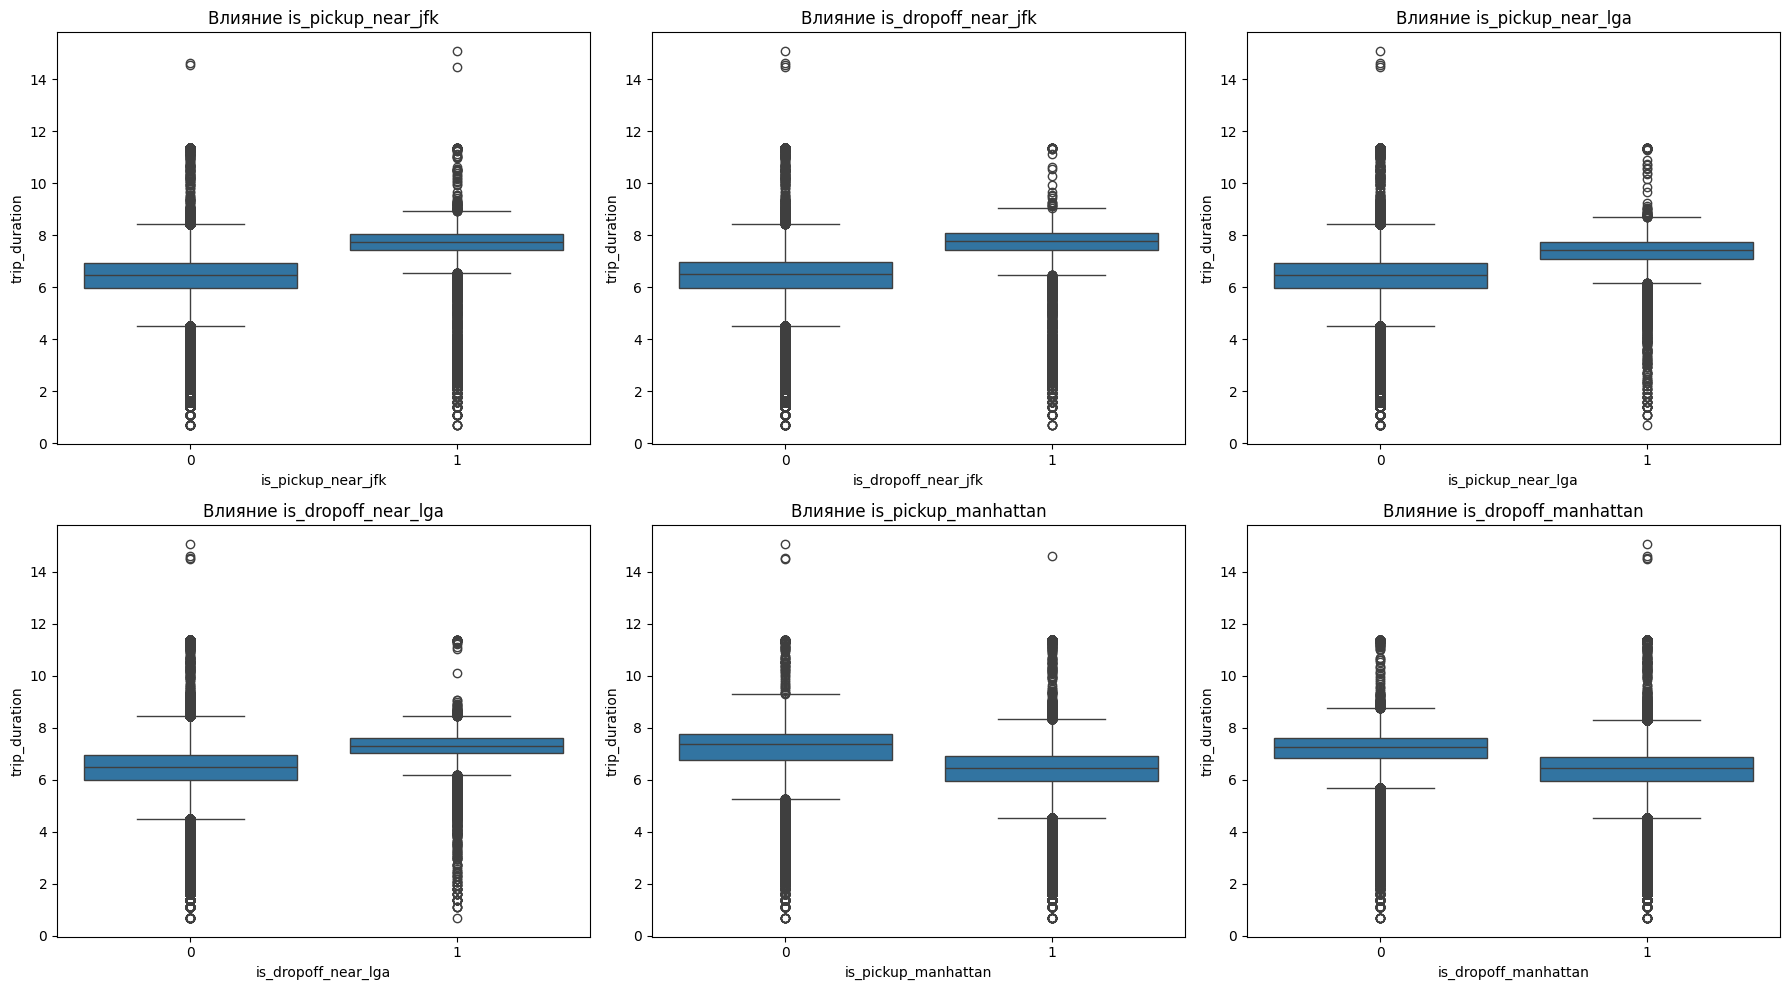

In [579]:
features = [
    "is_pickup_near_jfk",
    "is_dropoff_near_jfk",
    "is_pickup_near_lga",
    "is_dropoff_near_lga",
    "is_pickup_manhattan",
    "is_dropoff_manhattan",
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, feature in enumerate(features):
    ax = axes.flatten()[i]
    sns.boxplot(x=X_train_eda[feature], y=np.log1p(y_train_eda), ax=ax)
    ax.set_title(f"Влияние {feature}")

plt.tight_layout()
plt.show()

Признаки получились хорошие
1. **Аэропорты (JFK и LGA)**. Ящики для `1` (поездка в аэропорт) находятся существенно выше, чем для `0`. Медиана внутри ящиков смещена примерно с 6.5 до 8.0, в логарифмической шкале это большая разница. Модели будет легко различать поездки в аэропорт/ из аэропорта.

2. **Манхэттен**. Ящик для `1` (Манхэттен) расположен чуть ниже, чем для `0`. Медиана ниже. Это логично, ведь в пределах такого загруженного райнона как Манхэттен совершается большое количестов коротких поездок, в то время как за пределами Манхэттена совершается преимущественно длинные перегоны между районами или те же поездки в аэропорты.

**Добавление признаков на основе координатной сетки**

Для обработки нелинейности геоданных перейдем от непрерывных координат к дискретным номерам ячеек. Мы реализуем кастомный трансформер `MapGridTransformer`, который:

* **Накладывает сетку** $20 \times 10$ на центр Нью-Йорка.
* **Вычисляет индекс** ячейки по формуле: `row_idx * n_cols + col_idx`.
* **Создает два новых признака:** `pickup_cell` и `dropoff_cell`.
* **Помечает выбросы** (координаты вне сетки) значением `-1`.

In [580]:
class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_rows=20, n_cols=10):
        self.n_rows = n_rows
        self.n_cols = n_cols

        self.lat_min, self.lat_max = 40.70, 40.88
        self.lon_min, self.lon_max = -74.02, -73.93

    def fit(self, X=None, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()

        def get_cell_id(lat_series, lon_series):
            lat_step = (self.lat_max - self.lat_min) / self.n_rows
            lon_step = (self.lon_max - self.lon_min) / self.n_cols

            row_idx = np.floor((lat_series - self.lat_min) / lat_step).astype(
                int
            )
            col_idx = np.floor((lon_series - self.lon_min) / lon_step).astype(
                int
            )

            valid_mask = (
                (row_idx >= 0)
                & (row_idx < self.n_rows)
                & (col_idx >= 0)
                & (col_idx < self.n_cols)
            )

            cell_ids = np.where(
                valid_mask, row_idx * self.n_cols + col_idx, -1
            )

            return cell_ids

        X["pickup_cell"] = get_cell_id(
            X["pickup_latitude"], X["pickup_longitude"]
        )
        X["dropoff_cell"] = get_cell_id(
            X["dropoff_latitude"], X["dropoff_longitude"]
        )

        return X

    def show_map(self):
        m = folium.Map(
            location=[
                (self.lat_min + self.lat_max) / 2,
                (self.lon_min + self.lon_max) / 2,
            ],
            zoom_start=12,
        )
        folium.Rectangle(
            bounds=[
                [self.lat_min, self.lon_min],
                [self.lat_max, self.lon_max],
            ],
            color="red",
            fill=False,
            weight=3,
        ).add_to(m)

        return m

In [581]:
gridder = MapGridTransformer(n_rows=20, n_cols=10)

X_train_eda = gridder.fit_transform(X_train_eda)
X_test_eda = gridder.transform(X_test_eda)

X_train_eda["pickup_cell"].value_counts().head()

pickup_cell
-1     70354
 65    49102
 53    47591
 63    44021
 54    42244
Name: count, dtype: int64

In [582]:
gridder.show_map()

Обучим `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируем через one-hot-кодирование, числовые признаки отмасштабируем.

In [583]:
cat_columns = [
    "vendor_id",
    "store_and_fwd_flag",
    "pickup_day_of_week",
    "pickup_month",
    "pickup_hour",
    "pickup_cell",
    "dropoff_cell",
]
num_columns = [
    "passenger_count",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "pickup_day_of_year",
    "is_anomaly_period",
    "log_haversine",
    "is_rush_hour",
    "is_free_flow",
    "is_pickup_near_jfk",
    "is_dropoff_near_jfk",
    "is_pickup_near_lga",
    "is_dropoff_near_lga",
    "is_pickup_manhattan",
    "is_dropoff_manhattan",
]

model = get_pipeline(
    cat_columns, num_columns, Ridge(alpha=1.0, random_state=SEED)
)

model.fit(X_train_eda, np.log1p(y_train_eda))
y_pred_eda = model.predict(X_test_eda)
score = root_mean_squared_error(np.log1p(y_test_eda), y_pred_eda)
print(f"RMSLE score: {score}")

RMSLE score: 0.46847125597436456


После добавление новых признаков значение метрики существенно снизилось

### Оставшиеся признаки

У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

In [584]:
display(
    X_train_eda["vendor_id"].value_counts(),
    X_train_eda["passenger_count"].value_counts(),
    X_train_eda["store_and_fwd_flag"].value_counts(),
)

vendor_id
2    546566
1    474484
Name: count, dtype: int64

passenger_count
1    723614
2    147429
5     54532
3     41919
6     33707
4     19804
0        41
7         2
8         1
9         1
Name: count, dtype: int64

store_and_fwd_flag
N    1015403
Y       5647
Name: count, dtype: int64

Построим "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

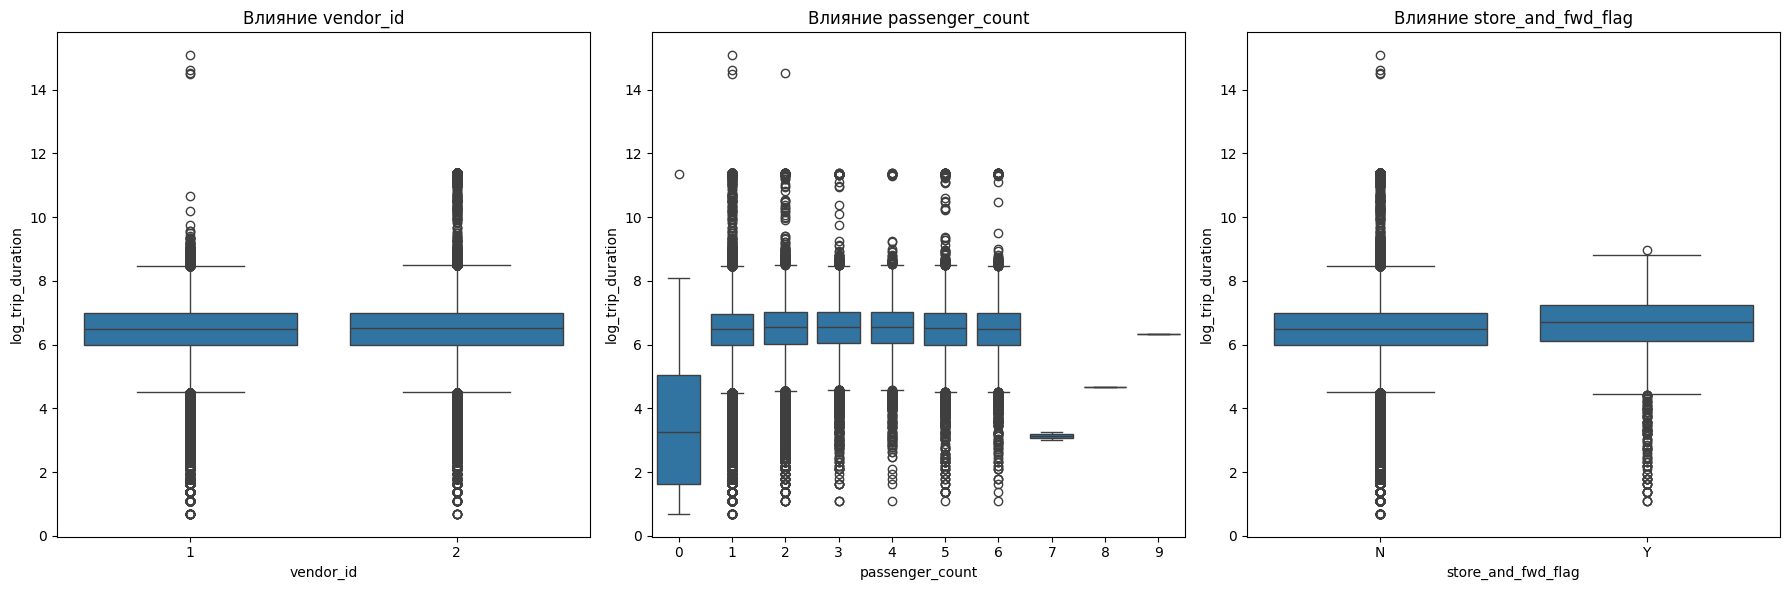

In [585]:
features = ["vendor_id", "passenger_count", "store_and_fwd_flag"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, feature in enumerate(features):
    sns.boxplot(x=X_train_eda[feature], y=np.log1p(y_train_eda), ax=axes[i])
    axes[i].set_title(f"Влияние {feature}")
    axes[i].set_ylabel("log_trip_duration")

plt.tight_layout()
plt.show()

Как можно заменить из графиков:
1. **`vendor_id`** почти никак не влияет на `log_trip_duration`. Это может быть связано с тем, что в Нью Йорке такси унифицировано: одинаковые машины, одинаково опытные водители, одинаковые таксометры. Этот признак слабый.
2. **`passenger_count`**. Группы 1,2,3,4,5,6 выглядят одинаково - время поездки не меняется от количества пассажиров в машине. Группа 0 смещена вниз относительно остальных, это очень короткие поездки. Скорее всего, это ошибки ввода, отмены или технические сбои. Группы 7,8,9 мусор - там либо одна точка, либо сплюснутый ящик.
Этот признак слабый для основной массы поездок.
3. **`store_and_fwd_flag`**. Разница в медианах минимальна. Основное отличие — отсутствие аномально коротких поездок в классе Y (связь с сервером чаще пропадает во время более длительных поездок). Однако, учитывая малую долю таких наблюдений (<1%), этот признак вряд ли даст существенный прирост качества модели.

Переведем признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$, чтобы не создавать лишние столбцы при кодировании One-Hot

In [586]:
def translate_to_int(df):
    df = df.copy()

    vendor_mapping = {1: 0, 2: 1}
    flag_mapping = {"N": 0, "Y": 1}

    df["vendor_id"] = df["vendor_id"].map(vendor_mapping).astype(int)
    df["store_and_fwd_flag"] = (
        df["store_and_fwd_flag"].map(flag_mapping).astype(int)
    )

    return df


X_train_eda = translate_to_int(X_train_eda)
X_test_eda = translate_to_int(X_test_eda)
X_train_eda[["vendor_id", "store_and_fwd_flag"]].dtypes

vendor_id             int64
store_and_fwd_flag    int64
dtype: object

Проверим предположения о бесполезности этих признаков, обучив `Ridge`-регрессию со стандартными параметрами.

In [587]:
cat_columns = [
    "pickup_day_of_week",
    "pickup_month",
    "pickup_hour",
    "pickup_cell",
    "dropoff_cell",
]
num_columns = [
    "passenger_count",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "pickup_day_of_year",
    "is_anomaly_period",
    "log_haversine",
    "is_rush_hour",
    "is_free_flow",
    "is_pickup_near_jfk",
    "is_dropoff_near_jfk",
    "is_pickup_near_lga",
    "is_dropoff_near_lga",
    "is_pickup_manhattan",
    "is_dropoff_manhattan",
    "vendor_id",
    "store_and_fwd_flag",
]

model = get_pipeline(
    cat_columns, num_columns, Ridge(alpha=1.0, random_state=SEED)
)

model.fit(X_train_eda, np.log1p(y_train_eda))
y_pred_eda = model.predict(X_test_eda)
score = root_mean_squared_error(np.log1p(y_test_eda), y_pred_eda)
print(f"RMSLE score: {score}")

RMSLE score: 0.468470981343551


Признаки не дали какого-то ощутимого улучшения метрики, их можно удалить.

Также подсчитаем остатки регрессии для следующего пукта

In [588]:
model.fit(X_train_eda, np.log1p(y_train_eda))

y_pred_train = model.predict(X_train_eda)
residuals = np.log1p(y_train_eda) - y_pred_train
residuals.head()

1011257    0.450120
178550    -0.178113
551460    -0.092181
1434271   -0.119016
1173610    0.057271
Name: trip_duration, dtype: float64

In [589]:
def drop_unnecessary_features(df):
    df = df.copy()
    df = df.drop(
        labels=["vendor_id", "passenger_count", "store_and_fwd_flag"], axis=1
    )
    return df


X_train_eda = drop_unnecessary_features(X_train_eda)
X_test_eda = drop_unnecessary_features(X_test_eda)

### Оценка выбросов

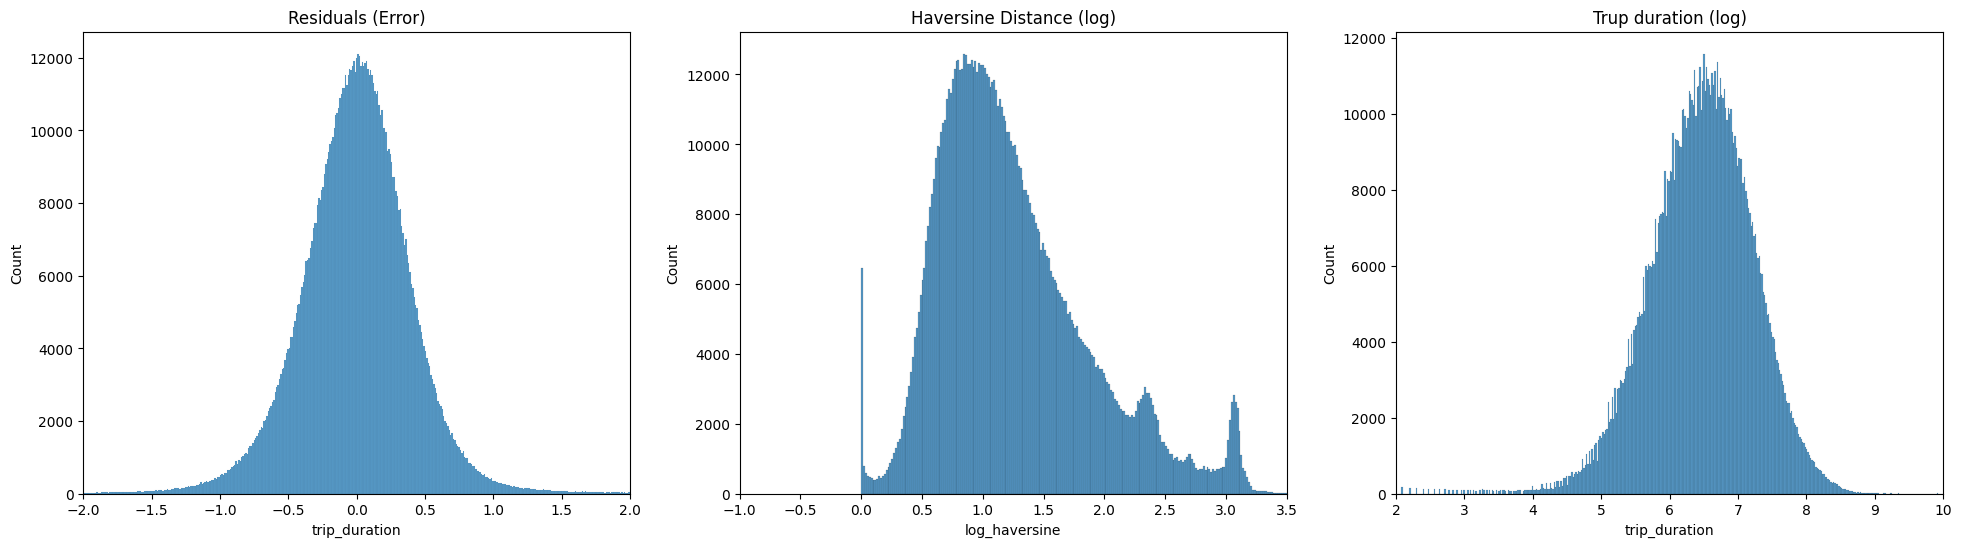

In [590]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

sns.histplot(residuals, ax=axes[0])
axes[0].set_title("Residuals (Error)")
axes[0].set_xlim(-2, 2)

sns.histplot(X_train_eda["log_haversine"], ax=axes[1])
axes[1].set_title("Haversine Distance (log)")
axes[1].set_xlim(-1, 3.5)

sns.histplot(np.log1p(y_train_eda), ax=axes[2])
axes[2].set_title("Trup duration (log)")
axes[2].set_xlim(2, 10)

plt.show()

Исключим наблюдения, для которых:
1. |`остатки регресии`| > 2
2. `log_haversine` = 0 и > 3.5
3. `log_trip_duration` < 4 и > 10

In [591]:
count_before = len(X_train_eda)

mask = (
    (np.abs(residuals) < 2)
    & (
        (X_train_eda["log_haversine"] > 0)
        & (X_train_eda["log_haversine"] < 3.5)
    )
    & ((np.log1p(y_train_eda) > 4) & (np.log1p(y_train_eda) < 10))
)

X_train_eda = X_train_eda[mask].copy()
y_train_eda = y_train_eda[mask].copy()

print(f"Было объектов: {count_before}")
print(f"Стало объектов: {len(X_train_eda)}")
print(f"Удалено: {count_before - len(X_train_eda)}")

Было объектов: 1021050
Стало объектов: 1009913
Удалено: 11137


Обучим `Ridge`-регрессию, чтобы посмотреть, как изменилось значение метрики

In [592]:
cat_columns = [
    "pickup_day_of_week",
    "pickup_month",
    "pickup_hour",
    "pickup_cell",
    "dropoff_cell",
]
num_columns = [
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "pickup_day_of_year",
    "is_anomaly_period",
    "log_haversine",
    "is_rush_hour",
    "is_free_flow",
    "is_pickup_near_jfk",
    "is_dropoff_near_jfk",
    "is_pickup_near_lga",
    "is_dropoff_near_lga",
    "is_pickup_manhattan",
    "is_dropoff_manhattan",
]

model = get_pipeline(
    cat_columns, num_columns, Ridge(alpha=1.0, random_state=SEED)
)

model.fit(X_train_eda, np.log1p(y_train_eda))
y_pred_eda = model.predict(X_test_eda)
score = root_mean_squared_error(np.log1p(y_test_eda), y_pred_eda)
print(f"RMSLE score: {score}")

RMSLE score: 0.4691995827481298


Значение метрики стало чуть хуже, но модель теперь будет вести себя стабильнее и меньше реагировать на шум при обучении

### Ridge vs Lasso

После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитаем колиество признаков до и после кодирования категориальных признаков.

In [593]:
n_before = len(cat_columns) + len(num_columns)
print("features before OHE:", n_before)

features before OHE: 20


In [595]:
pre = model.named_steps["prep"]
Xtr_enc = pre.transform(X_train_eda)
print("features after OHE:", Xtr_enc.shape[1])

features after OHE: 273


Попробуем обучить не `Ridge`-, а `Lasso`-регрессию.

In [596]:
lasso_model = get_pipeline(
    cat_columns,
    num_columns,
    Lasso(alpha=0.01, max_iter=20000, random_state=42),
)

lasso_model.fit(X_train_eda, np.log1p(y_train_eda))

ridge_model = get_pipeline(
    cat_columns, num_columns, Ridge(alpha=1.0, random_state=42)
)

y_pred_lasso = lasso_model.predict(X_test_eda)
rmsle_lasso = root_mean_squared_error(np.log1p(y_test_eda), y_pred_lasso)

y_pred_ridge = model.predict(X_test_eda)
rmsle_ridge = root_mean_squared_error(np.log1p(y_test_eda), y_pred_ridge)

print(f"Ridge RMSLE score: {rmsle_ridge}")
print(f"Lasso RMSLE score: {rmsle_lasso}")

Ridge RMSLE score: 0.4691995827481298
Lasso RMSLE score: 0.49452760382548744


Ridge лучше на тесте. Причина в том, что Lasso агрессивно зануляет веса и выкидывает часть one-hot признаков, из-за чего модель теряет информацию, а Ridge мягко "усаживает" веса и обычно стабильнее на разреженных one-hot матрицах.

**Подберем оптимальные значения параметра регуляризации для Ridge и Lasso**

In [597]:
X_train_eda, X_val_eda, y_train_eda, y_val_eda = train_test_split(
    X_train_eda,
    y_train_eda,
    test_size=0.2,
    random_state=SEED,
    shuffle=True,
)

X_train_eda.shape, y_train_eda.shape, X_val_eda.shape, y_val_eda.shape

((807930, 23), (807930,), (201983, 23), (201983,))

In [599]:
alphas = np.logspace(-4, 4, 15)
best = {
    "ridge": (None, np.inf, None),
    "lasso": (None, np.inf, None),
}

for a in alphas:
    m = get_pipeline(cat_columns, num_columns, Ridge(alpha=a, random_state=42))
    m.fit(X_train_eda, np.log1p(y_train_eda))
    y_pred = m.predict(X_val_eda)
    score = root_mean_squared_error(np.log1p(y_val_eda), y_pred)
    if score < best["ridge"][1]:
        best["ridge"] = (a, score, m)

zeros_by_alpha = []
scores_by_alpha = []
for a in alphas:
    m = get_pipeline(
        cat_columns,
        num_columns,
        Lasso(alpha=a, max_iter=20000, random_state=42),
    )
    m.fit(X_train_eda, np.log1p(y_train_eda))
    y_pred = m.predict(X_val_eda)
    score = root_mean_squared_error(np.log1p(y_val_eda), y_pred)

    coef = m.named_steps["model"].coef_
    n_zeros = np.sum(np.isclose(coef, 0.0))
    zeros_by_alpha.append(n_zeros)
    scores_by_alpha.append(score)

    if score < best["lasso"][1]:
        best["lasso"] = (a, score, m)


print("Best Ridge:", best["ridge"][:2])
print("Best Lasso:", best["lasso"][:2])

Best Ridge: (np.float64(13.89495494373136), 0.38691398434516194)
Best Lasso: (np.float64(0.0001), 0.38759560830661954)


In [600]:
best_alpha_ridge = best["ridge"][0]
final_ridge = get_pipeline(
    cat_columns, num_columns, Ridge(alpha=best_alpha_ridge, random_state=42)
)
final_ridge.fit(X_train_eda, np.log1p(y_train_eda))
test_pred = final_ridge.predict(X_test_eda)
test_rmsle = root_mean_squared_error(np.log1p(y_test_eda), test_pred)
best_rmsle = test_rmsle
print("Test RMSLE:", test_rmsle)

Test RMSLE: 0.4692216357220386


Для каждого перебранного `alpha` для Lasso посчитаем количество нулевых весов в модели и изобразим график зависимости его от `alpha`.

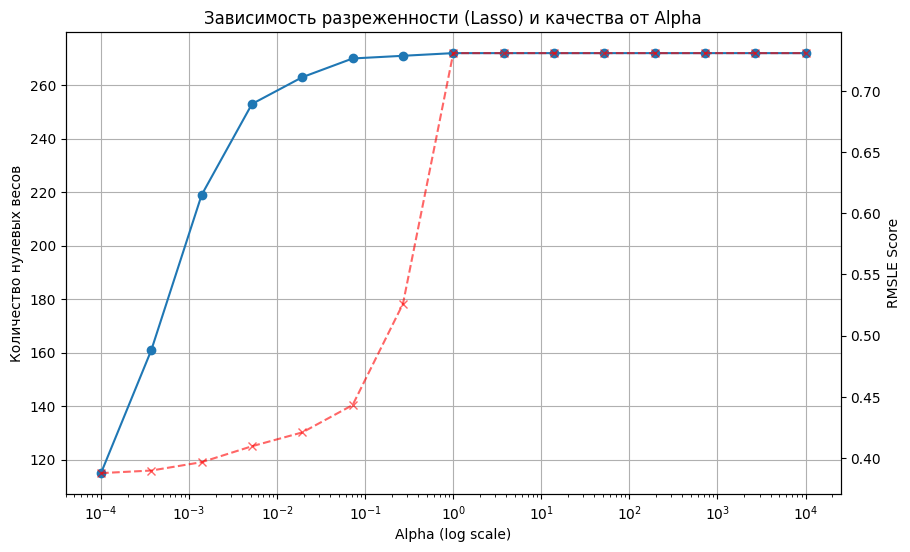

In [601]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(alphas, zeros_by_alpha, marker="o")
ax1.set_xlabel("Alpha (log scale)")
ax1.set_ylabel("Количество нулевых весов")
ax1.set_xscale("log")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel("RMSLE Score")
ax2.plot(
    alphas, scores_by_alpha, marker="x", linestyle="--", color="red", alpha=0.6
)

plt.title("Зависимость разреженности (Lasso) и качества от Alpha")
plt.show()

Также посмотрим, как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков

In [602]:
total_features = 273
threshold = total_features / 2

z_arr = np.array(zeros_by_alpha)
s_arr = np.array(scores_by_alpha)
a_arr = np.array(alphas)

mask = z_arr > threshold

if np.any(mask):
    idx = np.where(mask)[0][0]

    sparse_score = s_arr[idx]
    best_score = min(scores_by_alpha)
    diff = sparse_score - best_score

    print(
        f"Всего признаков: {total_features}. Порог удаления 50%: {threshold}"
    )
    print(f"---")
    print(f"Alpha для >50% нулей: {a_arr[idx]:.4f}")
    print(f"Количество нулей: {z_arr[idx]}")
    print(f"RMSLE этой модели: {sparse_score:.5f}")
    print(f"RMSLE лучшей Lasso модели: {best_score:.5f}")
    print(f"---")
    print(f"Потеря в качестве: {diff:.5f}")
else:
    print("В данном диапазоне alpha не удалось занулить половину признаков.")

Всего признаков: 273. Порог удаления 50%: 136.5
---
Alpha для >50% нулей: 0.0004
Количество нулей: 161
RMSLE этой модели: 0.38972
RMSLE лучшей Lasso модели: 0.38760
---
Потеря в качестве: 0.00212


Результаты эксперимента демонстрируют, что исходная модель содержала значительную избыточность, возникшую из-за One-Hot кодирования большого количества категориальных признаков. Применение Lasso-регуляризации позволило исключить более половины всех признаков (161 из 273), при этом ошибка прогноза (RMSLE) выросла всего на 0.002, что является пренебрежимо малой платой за существенное упрощение и ускорение модели. Это доказывает, что большинство сгенерированных признаков были шумовыми или малозначимыми, и их удаление сделало модель более компактной без реального ущерба для точности.

### Добавление популярных маршрутов (Feature Interactions)

Линейная модель суммирует веса старта и финиша независимо, упуская специфику конкретного пути (например, пробки на мосту между районами). Чтобы учесть это взаимодействие:

* **Создаем признак** `route_id` как комбинацию `pickup_cell` и `dropoff_cell`.
* **Выделяем топ-100** самых частых маршрутов как отдельные категории.
* **Редкие маршруты** кодируем значением `-1`.

In [603]:
def get_route_id(row):
    return f"{row['pickup_cell']}_{row['dropoff_cell']}"


train_routes = X_train_eda.apply(get_route_id, axis=1)
top100_routes = set(train_routes.value_counts().head(100).index)


def add_route_feature(df, top_routes):
    df = df.copy()
    routes = (
        df["pickup_cell"].astype(str) + "_" + df["dropoff_cell"].astype(str)
    )
    df["route_id"] = routes.apply(lambda x: x if x in top_routes else "-1")
    return df


X_train_eda = add_route_feature(X_train_eda, top100_routes)
X_test_eda = add_route_feature(X_test_eda, top100_routes)

print("Уникальных значений route_id:", X_train_eda["route_id"].nunique())

Уникальных значений route_id: 101


In [ ]:
cat_columns = [
    "pickup_day_of_week",
    "pickup_month",
    "pickup_hour",
    "pickup_cell",
    "dropoff_cell",
    "route_id",
]

num_columns = [
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "pickup_day_of_year",
    "is_anomaly_period",
    "log_haversine",
    "is_rush_hour",
    "is_free_flow",
    "is_pickup_near_jfk",
    "is_dropoff_near_jfk",
    "is_pickup_near_lga",
    "is_dropoff_near_lga",
    "is_pickup_manhattan",
    "is_dropoff_manhattan",
]

model = get_pipeline(
    cat_columns, num_columns, Ridge(alpha=best_alpha_ridge, random_state=SEED)
)

model.fit(X_train_eda, np.log1p(y_train_eda))
y_pred_eda = model.predict(X_test_eda)
score = root_mean_squared_error(np.log1p(y_test_eda), y_pred_eda)
print(f"RMSLE score: {score}")

RMSLE score: 0.464496778694715


In [606]:
X_train_eda.shape

(807930, 24)

# Submission

In [ ]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [613]:
def preprocess_data(df):
    df = df.copy()
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
    df = add_time_features(df)
    df = add_distance_features(df)
    df = add_traffic_features(df)
    df = add_airport_features(df)
    df = gridder.transform(df)
    df = drop_unnecessary_features(df)
    df = add_route_feature(df, top100_routes)
    return df


test_df = preprocess_data(test_df)
train_df = preprocess_data(train_df)

In [615]:
X = train_df.drop(["trip_duration", "id"], axis=1)
y = train_df["trip_duration"]

temp_model = get_pipeline(
    cat_columns, num_columns, Ridge(alpha=best_alpha_ridge, random_state=SEED)
)
temp_model.fit(X, np.log1p(y))

preds = temp_model.predict(X)
residuals = np.log1p(y) - preds

mask = (
    (np.abs(residuals) < 2)
    & ((X["log_haversine"] > 0) & (X["log_haversine"] < 3.5))
    & ((np.log1p(y) > 4) & (np.log1p(y) < 10))
)

X_clean = X[mask].copy()
y_clean = y[mask].copy()

In [ ]:
final_model = get_pipeline(
    cat_columns, num_columns, Ridge(alpha=best_alpha_ridge, random_state=42)
)

final_model.fit(X_clean, np.log1p(y_clean))

In [611]:
log_predictions = model.predict(test_df)
predictions = np.expm1(log_predictions)

submission_df = pd.DataFrame(
    {"id": test_df["id"], "trip_duration": predictions}
)
submission_df.to_csv("submission.csv", index=False)